# Drifing Upstream: Modeling

We are now at the modeling stage of our data pipeline. After exploring some initial models during the preprocessing and training phase, we grew concerned that the music features we were working with didn't provide enough predictive power, as our prediction's mean absolute error was consistently over 300 million streams. Thus, we returned to Kaggle and found this __[dataset](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)__ that includes 32,833 songs on Spotify, along with more features. More details on the data wrangling and exploration can be found __[here](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/dw_and_eda_2.ipynb)__. 

In addition to categorical columns pertaining to key, genre, and subgenre, this dataset also includes 2 numerical columns: loudness and duration, that we think might be crucial in helping improve our model's predictive power. However, this dataset doesn't include songs that were released after 2020, so our predictive insights might lose a degree of generalizeability to present data, compared with data on more recent releases, which of course is the aim of this study. Nonetheless, if loudness and duration indeed prove to be key features in boosting predictive capability, we will build the model upon this dataset with those features and inform Regression Records that further tuning can be adjusted accordingly when new data are retrieved on all relevent music features of more recently released songs. Because this dataset spans songs released from 1957-2020, we believe that it will provide a broad view of __[popular music features over time](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/tsa_2.ipynb)__.

A note on the target variable: this dataset ranks a song's populartity on a score from 1-100, rather than total stream count as our previous playlist did. Our target variable will be popularity score. And as we seek to be in the upper half of the relative data, we aim to achieve a popularity score of > 50, or rather, > 50 + mean absolute error.

## Load Libraries

In [398]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import optuna

## Load Data

In [401]:
df = pd.read_csv('spotify_30k_cleaned.csv', index_col=0)
df.head()

,y,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,66,0.748,0.916,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,...,0,0,0,0,0,0,0,1,0,0
1,67,0.726,0.815,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,...,1,0,0,0,0,0,0,0,0,0
2,70,0.675,0.931,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,...,0,0,1,0,0,0,0,0,0,0
3,60,0.718,0.930,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,...,0,0,0,0,0,0,0,0,1,0
4,69,0.650,0.833,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,...,0,0,1,0,0,0,0,0,0,0


## Train/Test Split

In [10]:
X = df.drop(columns='y')
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Test shape: {X_test.shape, y_test.shape}')

Train shape: ((26266, 53), (26266,))
Test shape: ((6567, 53), (6567,))


## Cross Validation and Baseline Prediction

In [12]:
# Declare function to return lowest mean absolute error of cross validated score for a model
def cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae = make_scorer(mean_absolute_error)
    scores = cross_val_score(model, X_train, y_train, scoring=mae, cv=kf)
    return np.min([np.mean(scores), np.median([scores])])

In [13]:
# Set benchmark MAE by predicting the mean popularity
dumb_reg = DummyRegressor(strategy='mean')
cv(dumb_reg)

20.910716327965822

<div class="alert alert-block alert-info">If we predict by merely guessing the mean, we can expect for our predicted popularity score to be off by almost 21.</div>

## Random Forest Regressor

In [50]:
# Untuned Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
cv(rf)

17.241453097096443

In [33]:
#Hyperparameter tuning
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
    max_features = trial.suggest_int('max_features', 4, 53)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae = make_scorer(mean_absolute_error)
    scores = cross_val_score(model, X_train, y_train, scoring=mae, cv=kf)
    return np.min([np.mean(scores), np.median([scores])])

In [77]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)
#Cleared output of this cell to minimize long output from progress bar (used to visualize progress during runtime)
#Best results indicated below

In [35]:
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

Best trial: FrozenTrial(number=13, state=1, values=[17.21457382311874], datetime_start=datetime.datetime(2024, 3, 30, 15, 1, 49, 358781), datetime_complete=datetime.datetime(2024, 3, 30, 15, 27, 37, 898407), params={'n_estimators': 892, 'max_features': 53, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=True, low=100, step=1), 'max_features': IntDistribution(high=53, log=False, low=4, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=13, value=None)
Best hyperparameters: {'n_estimators': 892, 'max_features': 53, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [84]:
#Instantiate best model and fit to training data
rf = RandomForestRegressor(n_estimators=892, max_features=53, max_depth=32, min_samples_split=4, min_samples_leaf=1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=32, max_features=53, min_samples_split=4,
                      n_estimators=892, random_state=42)

In [85]:
#Evaluate feature importances
rf_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':rf.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
rf_fi.head(15)

,Feature,Importance
0,duration,0.088262
1,loudness,0.087503
2,energy,0.085908
3,tempo,0.081525
4,instrumentalness,0.081167
5,speechiness,0.075896
6,danceability,0.075640
7,valence,0.074692
8,acousticness,0.073575
9,liveness,0.072445


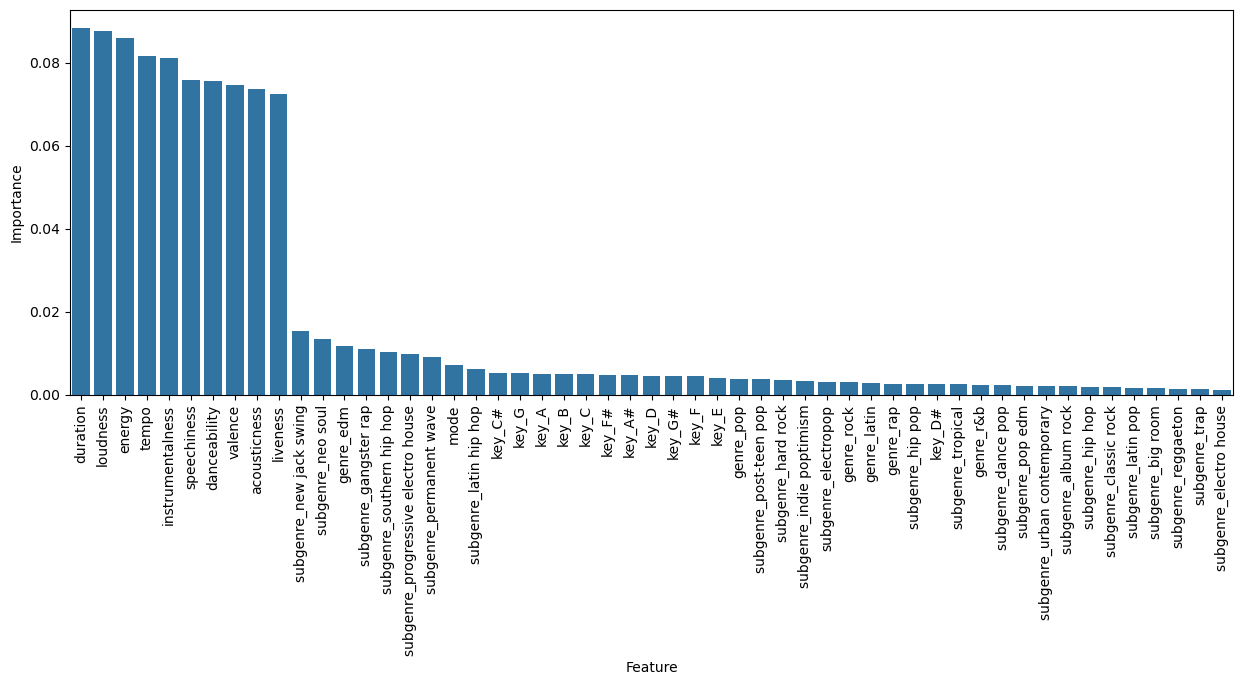

In [86]:
plt.subplots(figsize=(15,5));
sns.barplot(rf_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);

<div class="alert alert-block alert-info">All of the numerical music features are significantly more important than any of the categorical music features. Additionally, duration and loudness are the two most important features. This confirms that we are likely to have stronger predictive ability working with a dataset that includes these features. We will therefore proceed in our analysis with this dataset, rather than our prior set that excludes duration and loudness. Also, given the drop in importance of categorical features, we will compare the mean absolute error of a prediction that only uses numerical features. If the result is similar, we will drop categorical features from the training set and proceed to only use the numerical features. </div>

In [15]:
#Compare model performance only using most relevant features
df_num = df[['duration', 'loudness', 'energy', 'tempo', 'instrumentalness', 
             'speechiness', 'danceability', 'valence', 'acousticness', 'liveness']]

X_train, X_test, y_train, y_test = train_test_split(df_num, y, test_size=0.2, random_state=42)

In [88]:
cv(rf)

16.948918804828406

<div class="alert alert-block alert-info">Indeed, the prediction actually improved when we only used the numerical features. To speed up compute time and simplify the necessary feature selection for our models, we will continue to use the refined dataset that only considers numerical features. If we had a longer timeline for this project, we could test the comparative performance of the model with the inclusion of each categorical variable, running a new simulation for each new variable added, but given our current timeline we will opt to expedite by working with only the numerical variables. Future analysis might consider a more robust examination of key's and genre's potential influence on song popularity.</div>

In [73]:
#Compare with untuned model on new train set
rf = RandomForestRegressor(random_state=42)
cv(rf)

16.938028596828854

__[Additional Random Forest hyperparameter tuning.](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/Hyperparameter_Tuning/hpt_rf.ipynb)__

In [16]:
#Best model
rf = RandomForestRegressor(n_estimators=1554, max_depth=39, random_state=42, n_jobs=-1)

#Scale features and fit best model
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=39, n_estimators=1554, n_jobs=-1,
                      random_state=42)

In [17]:
#Feature importance dataframe
rf_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':rf.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
rf_fi

,Feature,Importance
0,duration,0.113663
1,loudness,0.110351
2,tempo,0.105200
3,energy,0.101374
4,speechiness,0.098280
5,acousticness,0.096916
6,valence,0.095318
7,danceability,0.094463
8,instrumentalness,0.092700
9,liveness,0.091735


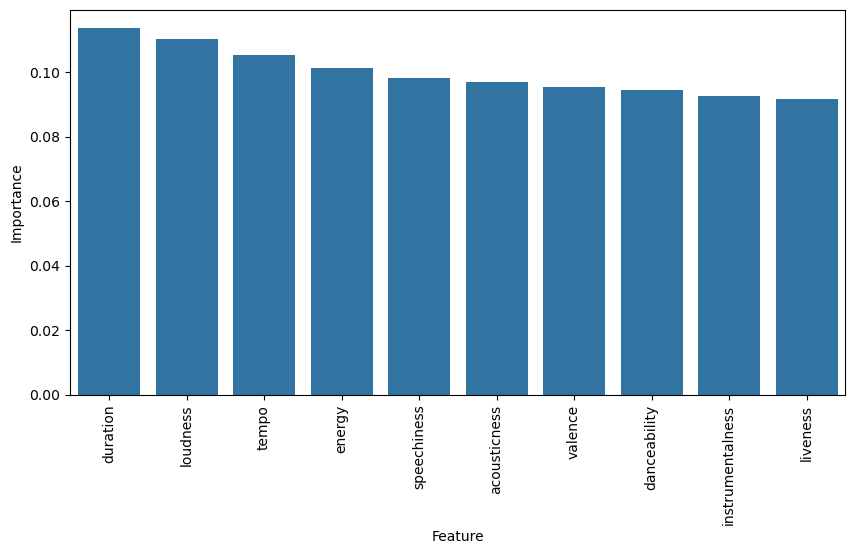

In [18]:
#Feature importance plot
plt.subplots(figsize=(10,5));
sns.barplot(rf_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);

In [19]:
#CV scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae = make_scorer(mean_absolute_error)
rf_scores = cross_val_score(rf, X_train_scaled, y_train, scoring=mae, cv=kf, n_jobs=-1)
rf_score_mean = np.mean(rf_scores)
rf_score_std = np.std(rf_scores)

#Test prediction score
rf_pred = rf.predict(X_test_scaled)
rf_pred_score = mean_absolute_error(y_test, rf_pred)

In [22]:
print(f'Random Forest MAE\n\nCV Mean: {rf_score_mean}\nCV Std: {rf_score_std}\nTest Pred: {rf_pred_score}')

Random Forest MAE

CV Mean: 16.86023393955105
CV Std: 0.09942792642775837
Test Pred: 16.313471746006556


## Extra Trees Regressor

In [63]:
# Untuned Extra Trees Regressor
et = ExtraTreesRegressor(random_state=42)
cv(et)

15.982976444299402

__[Additional Extra Trees hyperparameter tuning.](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/Hyperparameter_Tuning/hpt_et.ipynb)__

In [23]:
#Best model
et = ExtraTreesRegressor(n_estimators=1458, max_depth=46, random_state=42, n_jobs=-1)

#Scale features and fit best model
scaler = PowerTransformer()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
et.fit(X_train_scaled, y_train)

ExtraTreesRegressor(max_depth=46, n_estimators=1458, n_jobs=-1, random_state=42)

In [24]:
#Feature importance dataframe
et_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':et.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
et_fi

,Feature,Importance
0,duration,0.106840
1,instrumentalness,0.106628
2,loudness,0.105952
3,energy,0.104153
4,acousticness,0.099422
5,tempo,0.095905
6,valence,0.095804
7,speechiness,0.095739
8,danceability,0.095383
9,liveness,0.094174


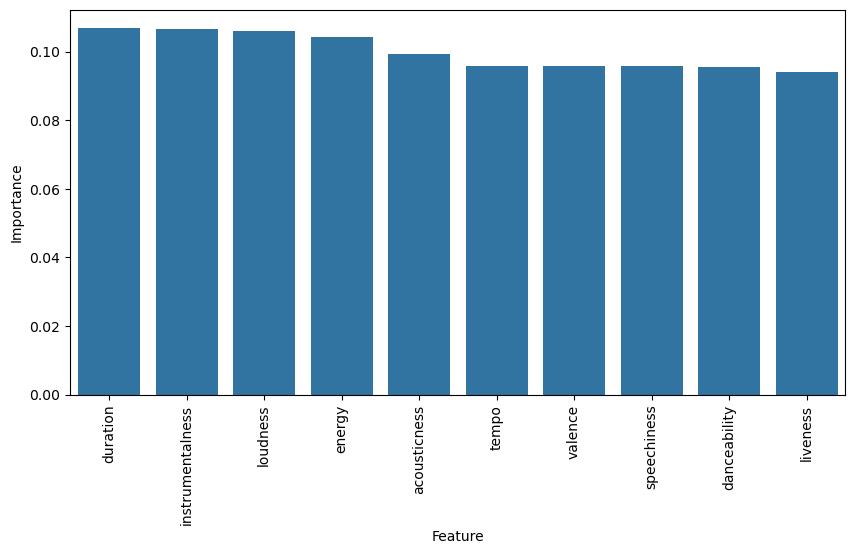

In [25]:
#Feature importance plot
plt.subplots(figsize=(10,5));
sns.barplot(et_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);

In [26]:
#CV scores
et_scores = cross_val_score(et, X_train_scaled, y_train, scoring=mae, cv=kf, n_jobs=-1)
et_score_mean = np.mean(et_scores)
et_score_std = np.std(et_scores)

#Test prediction score
et_pred = et.predict(X_test_scaled)
et_pred_score = mean_absolute_error(y_test, et_pred)

In [27]:
print(f'Extra Trees MAE\n\nCV Mean: {et_score_mean}\nCV Std: {et_score_std}\nTest Pred: {et_pred_score}')

Extra Trees MAE

CV Mean: 15.936575985093796
CV Std: 0.08829270949863222
Test Pred: 15.30191608911115


## Gradient Boosting Regressor

In [9]:
#Untuned Gradient Boosing Regressor
gb = GradientBoostingRegressor(random_state=42)
cv(gb)

19.592463083023425

__[Additional Gradient Boosting hyperparameter tuning.](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/Hyperparameter_Tuning/hpt_gb.ipynb)__

In [28]:
#Best model
gb = GradientBoostingRegressor(n_estimators=657, learning_rate=0.17213162542313915, max_depth=16, 
                               min_samples_split=6, min_samples_leaf=19, random_state=42)

#Scale features and fit best model
scaler = MinMaxScaler()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
gb.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.17213162542313915, max_depth=16,
                          min_samples_leaf=19, min_samples_split=6,
                          n_estimators=657, random_state=42)

In [29]:
#Feature importance dataframe
gb_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':gb.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
gb_fi

,Feature,Importance
0,duration,0.115055
1,tempo,0.114567
2,loudness,0.113379
3,speechiness,0.097661
4,acousticness,0.096410
5,energy,0.093515
6,valence,0.093406
7,instrumentalness,0.092583
8,danceability,0.091888
9,liveness,0.091535


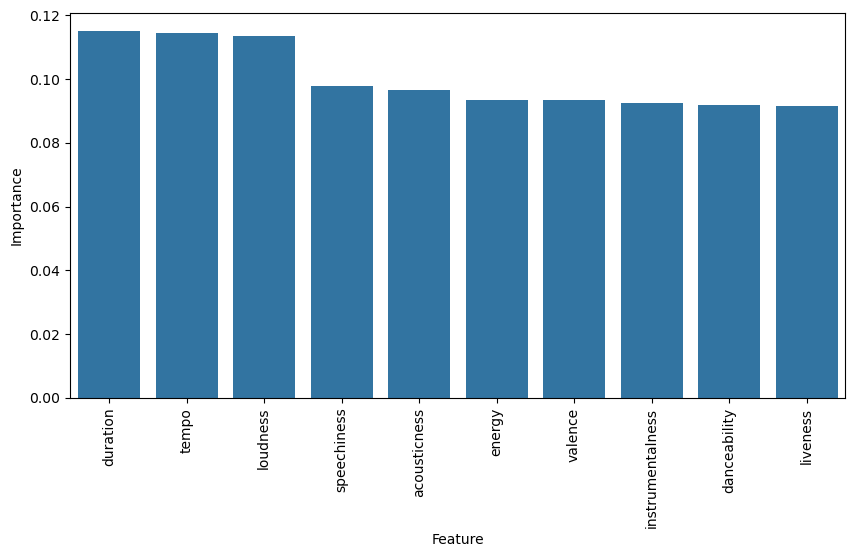

In [30]:
#Feature importance plot
plt.subplots(figsize=(10,5));
sns.barplot(gb_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);

In [31]:
#CV scores
gb_scores = cross_val_score(gb, X_train_scaled, y_train, scoring=mae, cv=kf, n_jobs=-1)
gb_score_mean = np.mean(gb_scores)
gb_score_std = np.std(gb_scores)

#Test prediction score
gb_pred = gb.predict(X_test_scaled)
gb_pred_score = mean_absolute_error(y_test, gb_pred)

In [32]:
print(f'Gradient Boosting MAE\n\nCV Mean: {gb_score_mean}\nCV Std: {gb_score_std}\nTest Pred: {gb_pred_score}')

Gradient Boosting MAE

CV Mean: 16.826025658963506
CV Std: 0.11903234927704118
Test Pred: 16.00320005435396


## Hist Gradient Boosting Regressor

In [10]:
#Untuned Hist Gradient Boosting Regressor
hgb = HistGradientBoostingRegressor(random_state=42)
cv(hgb)

19.148164650154964

__[Additional Hist Gradient Boosting hyperparameter tuning.](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/Hyperparameter_Tuning/hpt_hgb.ipynb)__

In [34]:
#Best model
hgb = HistGradientBoostingRegressor(learning_rate=0.05210537299041002, max_iter=1253, max_depth=27, min_samples_leaf=31, 
                                    max_leaf_nodes=148, l2_regularization=0.044204117745388065, random_state=42)

#Scale features and fit best model
scaler = RobustScaler()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
hgb.fit(X_train_scaled, y_train)

HistGradientBoostingRegressor(l2_regularization=0.044204117745388065,
                              learning_rate=0.05210537299041002, max_depth=27,
                              max_iter=1253, max_leaf_nodes=148,
                              min_samples_leaf=31, random_state=42)

In [36]:
# Hist Gradient Booster has no feature importance attribute

In [37]:
#CV scores
hgb_scores = cross_val_score(hgb, X_train_scaled, y_train, scoring=mae, cv=kf, n_jobs=-1)
hgb_score_mean = np.mean(hgb_scores)
hgb_score_std = np.std(hgb_scores)

#Test prediction score
hgb_pred = hgb.predict(X_test_scaled)
hgb_pred_score = mean_absolute_error(y_test, hgb_pred)

In [38]:
print(f'Hist Gradient Boosting MAE\n\nCV Mean: {hgb_score_mean}\nCV Std: {hgb_score_std}\nTest Pred: {hgb_pred_score}')

Hist Gradient Boosting MAE

CV Mean: 18.241643068804468
CV Std: 0.19786301962386998
Test Pred: 17.683754450810966


## XGBoost Regressor

In [14]:
#Untuned XGBoost Regressor
xgb = XGBRegressor(random_state=42)
cv(xgb)

18.869175368861864

__[Additional XGBoost hyperparameter tuning.](https://github.com/david92russell/Drifting_Upstream/blob/main/Notebooks/Hyperparameter_Tuning/hpt_xgb.ipynb)__

In [39]:
#Best model
xgb = XGBRegressor(learning_rate=0.22104387821944305, gamma=0.4918595690664665, max_depth=10, min_child_weight=2, 
                   subsample=0.9280489884605818, colsample_bytree=0.8521107556733699, random_state=42)

#Scale features and fit best model
scaler = PowerTransformer()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8521107556733699, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4918595690664665, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.22104387821944305, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [40]:
#Feature importance dataframe
xgb_fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb.feature_importances_}).sort_values(
                    'Importance', ascending=False).reset_index(drop=True)
xgb_fi

,Feature,Importance
0,instrumentalness,0.118265
1,tempo,0.111191
2,energy,0.102951
3,liveness,0.102194
4,loudness,0.099779
5,acousticness,0.098913
6,valence,0.094582
7,speechiness,0.093796
8,danceability,0.091276
9,duration,0.087051


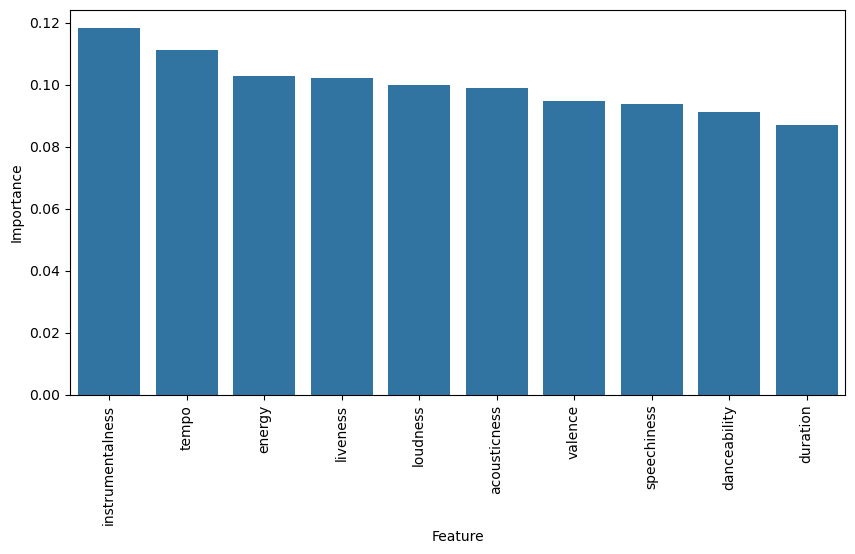

In [41]:
#Feature importance plot
plt.subplots(figsize=(10,5));
sns.barplot(xgb_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);

In [42]:
#CV scores
xgb_scores = cross_val_score(xgb, X_train_scaled, y_train, scoring=mae, cv=kf, n_jobs=-1)
xgb_score_mean = np.mean(xgb_scores)
xgb_score_std = np.std(xgb_scores)

#Test prediction score
xgb_pred = xgb.predict(X_test_scaled)
xgb_pred_score = mean_absolute_error(y_test, xgb_pred)

In [43]:
print(f'XGBoost MAE\n\nCV Mean: {xgb_score_mean}\nCV Std: {xgb_score_std}\nTest Pred: {xgb_pred_score}')

XGBoost MAE

CV Mean: 17.622566481974907
CV Std: 0.13984994917622798
Test Pred: 17.28861440812625


## Model Comparison: Feature Importance

In [151]:
#Datafrrame comparing feature importance per model
df_fi = rf_fi.merge(et_fi, on='Feature', suffixes=['_rf', '_et'])
df_fi = df_fi.merge(gb_fi, on='Feature')
df_fi = df_fi.merge(xgb_fi, on='Feature')
df_fi = df_fi.rename(columns={'Importance_rf': 'rf', 'Importance_et': 'et', 'Importance_x': 'gb', 'Importance_y': 'xgb'})
df_fi

,Feature,rf,et,gb,xgb
0,duration,0.113663,0.106840,0.115055,0.087051
1,loudness,0.110351,0.105952,0.113379,0.099779
2,tempo,0.105200,0.095905,0.114567,0.111191
3,energy,0.101374,0.104153,0.093515,0.102951
4,speechiness,0.098280,0.095739,0.097661,0.093796
5,acousticness,0.096916,0.099422,0.096410,0.098913
6,valence,0.095318,0.095804,0.093406,0.094582
7,danceability,0.094463,0.095383,0.091888,0.091276
8,instrumentalness,0.092700,0.106628,0.092583,0.118265
9,liveness,0.091735,0.094174,0.091535,0.102194


In [152]:
#Melt dataframe for plotting
df_fi_m = pd.melt(df_fi, id_vars='Feature', var_name='Model', value_name='Importance')
df_fi_m.head(15)

,Feature,Model,Importance
0,duration,rf,0.113663
1,loudness,rf,0.110351
2,tempo,rf,0.105200
3,energy,rf,0.101374
4,speechiness,rf,0.098280
5,acousticness,rf,0.096916
6,valence,rf,0.095318
7,danceability,rf,0.094463
8,instrumentalness,rf,0.092700
9,liveness,rf,0.091735


In [163]:
#Average importance of each feature across models
fi_means = [x for x in df_fi.iloc[:,1:].mean(axis=1)]
fi_means

[0.10565249412446674,
 0.10736510990381527,
 0.10671598265847332,
 0.10049820420290129,
 0.09636900852396778,
 0.09791528636868525,
 0.09477751852546978,
 0.09325267113838145,
 0.10254401826380924,
 0.09490971374061036]

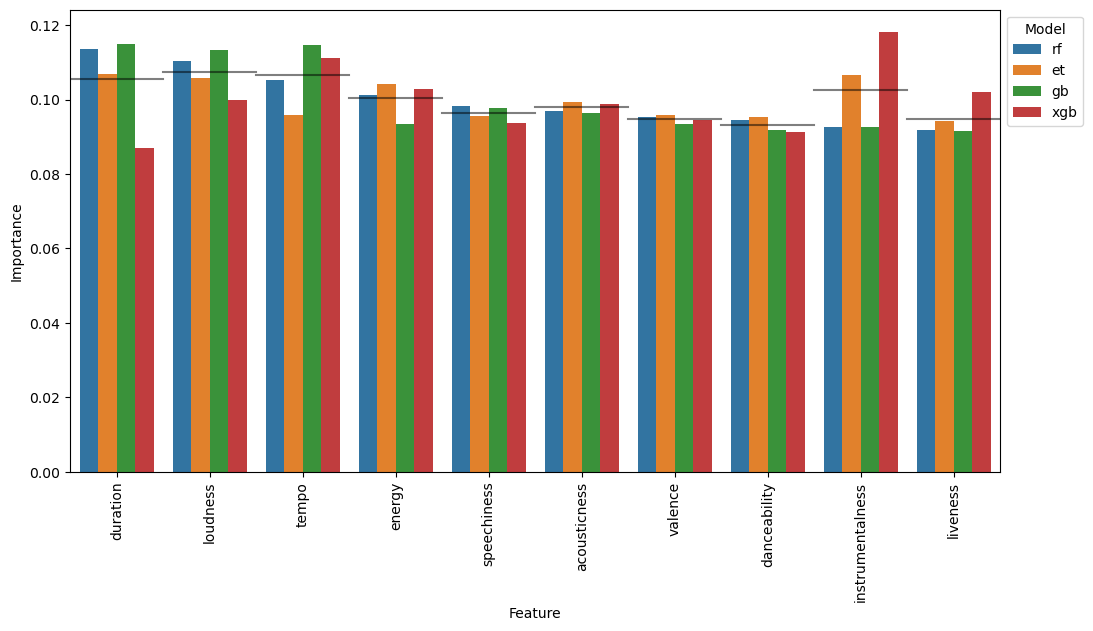

In [160]:
#Grouped barplot showing feature importance for each model; horizontal lines indicate mean of each feature's importance across models
plt.subplots(figsize=(12, 6));
ax = sns.barplot(data=df_fi_m, x='Feature', y='Importance', hue='Model');
plt.xticks(rotation=90);
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1));
for x in range(10):
    plt.axhline(y=fi_means[x], xmin=x*0.1, xmax=x*0.1+0.1, c='black', alpha=0.5);

<div class="alert alert-block alert-info">We can see that models demonstrated greater consistency in the feature importance of speechiness, acousticness, valence, and danceability, and greater variability in the importance of duration, loudness, tempo, energy, instrumentalness, and liveness. In general, XGBoost seemed to rank feature importance more differently than the other models relative to one another, with it placing a noticeably higher importance on instrumentalness and a lower importance on duration than the other models. By looking at the average importance of features across models (as indicated by the black horizontal lines), we see that duration, loudness, tempo, and instrumentalness are overall the most important features. (We note that this doesn't include the Hist Gradient Boosting model, as this model doesn't have a feature importance attribute). Let's now examine the relative performance of all five models that we tested.</div>

## Model Comparison: Predictive Performance

In [203]:
#Dataframe of models and their respective CV and test mean absolute errors
df_mp = pd.DataFrame({
    'Model': ['rf', 'et', 'gb', 'hgb', 'xgb'],
    'CV MAE Mean': [rf_score_mean, et_score_mean, gb_score_mean, hgb_score_mean, xgb_score_mean],
    'Test MAE': [rf_pred_score, et_pred_score, gb_pred_score, hgb_pred_score, xgb_pred_score]
})
df_mp

,Model,CV MAE Mean,Test MAE
0,rf,16.860234,16.313472
1,et,15.936576,15.301916
2,gb,16.826026,16.003200
3,hgb,18.241643,17.683754
4,xgb,17.622566,17.288614


In [204]:
#Melted dataframe for plotting
df_mp_m = pd.melt(df_mp, id_vars='Model', var_name='Metric', value_name='Score')
df_mp_m

,Model,Metric,Score
0,rf,CV MAE Mean,16.860234
1,et,CV MAE Mean,15.936576
2,gb,CV MAE Mean,16.826026
3,hgb,CV MAE Mean,18.241643
4,xgb,CV MAE Mean,17.622566
5,rf,Test MAE,16.313472
6,et,Test MAE,15.301916
7,gb,Test MAE,16.003200
8,hgb,Test MAE,17.683754
9,xgb,Test MAE,17.288614


In [193]:
#Standard Deviations for CV Scores across models
stds = [rf_score_std, et_score_std, gb_score_std, hgb_score_std, xgb_score_std]
stds

[0.09942792642775837,
 0.08829270949863222,
 0.11903234927704118,
 0.19786301962386998,
 0.13984994917622798]

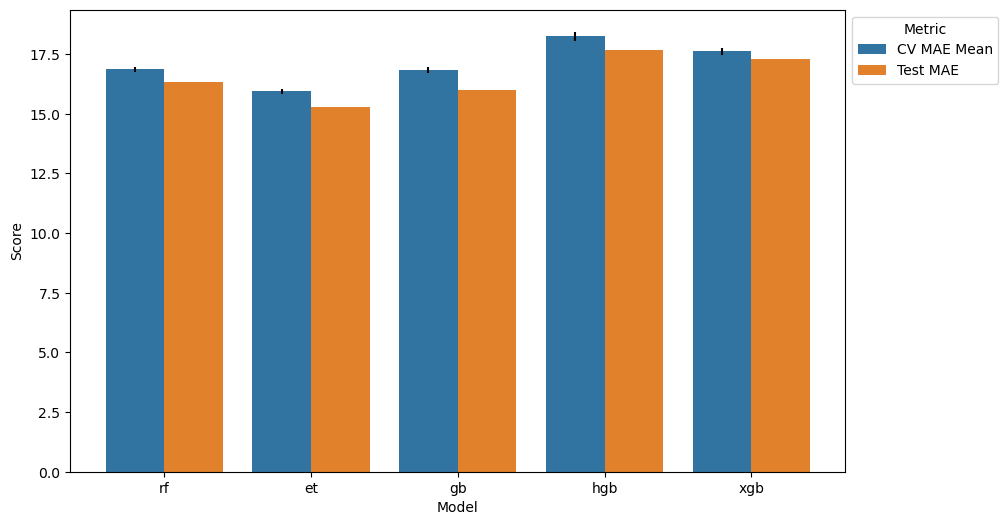

In [207]:
#Grouped barplot showing average cross validated mean absolute error and test MAE per model; error bar indicates standard deviation
plt.subplots(figsize=(10, 6));
ax = sns.barplot(data=df_mp_m, x='Model', y='Score', hue='Metric');
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1));
for s in range(5):
    plt.errorbar(x=s-0.2, y=df_mp['CV MAE Mean'][s], yerr=stds[s], c='black');

<div class="alert alert-block alert-info">As we want for the mean absolute error to be lower, the shorter bars indicate better results. It is clear that the Extra Trees Regressor is our best model. It has both the smallest cross validated mean absolute error on the train set, and the smallest mean absolute error on the test set predictions, as well as the smallest standard deviation, ensuring more reliability in the model's reproducibility. Interestingly, the test set performance is better than the averaged results from the cross validated train set. This is likely due to a greater outlier in the train set, making predictions with those data more variable than the those of the test set. This works to our favor though, as the lower MAE for the test set indicates that our models are not overfit to the training data.</div>

## Quantifying Target Variable

In [396]:
#Look at original dataframe before cleaning and EDA to reference track info
df_info = pd.read_csv('spotify_30k.csv')
df_info.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [397]:
df_info.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [380]:
#Take 21 random samples with popularity scores in incriments of 5
df_q = pd.DataFrame()

for i in range(0, 105, 5):
    df_q = pd.concat([df_q, df_info[df_info['track_popularity'] == i].sample(random_state=21)], axis=0)

df_q = df_q[['track_name', 'track_artist', 'track_popularity']]
df_q

,track_name,track_artist,track_popularity
18072,Ojitos Cafe,18 Kilates,0
22700,At Seventeen,Janis Ian,5
11927,"Everybody's Talkin' - From ""Midnight Cowboy""",Harry Nilsson,10
2135,Umbrella,Rihanna,15
28190,One Night of Karma,Tetengo,20
31553,Existence,Deorro,25
28777,Arcadia,Hardwell,30
13171,Awa adounia,Liya Ag Ablil,35
24887,Things We Do For Love,Horace Brown,40
7501,Medicine Man,Dorothy,45


In [381]:
#Look up Spotify stream counts for each of these songs
stream_counts_1 = [
    203_298, 35_110_396, 146_352_375,
    1_475_006_835, 69_275, 3_610_236,
    11_717_492, 3_356_144, 7_861_543,
    8_145_877, 13_422_026, 869_826_917,
    1_369_018_712, 140_383_528, 294_057_696,
    1_566_959_620, 62_823_171, 1_164_649_355,
    372_038_304, 2_475_759_804, 3_026_456_716]

In [382]:
#Add a new column with stream counts for corresponding songs from sample
df_q['streams_1'] = stream_counts_1
df_q = df_q.drop(columns=['track_name', 'track_artist']).reset_index(drop=True)

In [383]:
#Given that we have some large fluctuations in our sample that challenge its reliability, we'll repeat the process two more times
df_q2 = pd.DataFrame()

for i in range(0, 105, 5):
    df_q2 = pd.concat([df_q2, df_info[df_info['track_popularity'] == i].sample(random_state=42)], axis=0)

df_q2 = df_q2[['track_name', 'track_artist', 'track_popularity']]
df_q2

,track_name,track_artist,track_popularity
13315,Hysteria 2013 (Re-Recorded Version) - Single,Def Leppard,0
3897,Beautiful Girl - Radio Edit,Junge Junge,5
29372,Shots & Squats,Vigiland,10
31708,Bailar la Soca,Cuba Trinidad,15
5483,Get Weird,Liimo,20
5239,Crawl,TENDER,25
21618,get away,una schram,30
32244,Colourblind - Radio Edit,Thomas Gold,35
28625,Feelings - Spada Remix,Deep Chills,40
11099,CHAT,Young Cister,45


In [384]:
stream_counts_2 = [
    187_690_733, 27_590_280, 235_631_318,
    91_546, 539_657, 1_283_621, 
    89_999, 3_169_839, 894_175, 
    3_316_378, 8_418_762, 24_372_578, 
    11_669_047, 148_803_010, 233_024_054, 
    120_992_346, 1_727_367_830, 1_034_507_823,
    372_038_304, 783_493_692, 3_026_456_716]

In [385]:
df_q2['streams_2'] = stream_counts_2
df_q2 = df_q2.drop(columns=['track_name', 'track_artist']).reset_index(drop=True)

In [386]:
df_q3 = pd.DataFrame()

for i in range(0, 105, 5):
    df_q3 = pd.concat([df_q3, df_info[df_info['track_popularity'] == i].sample(random_state=63)], axis=0)

df_q3 = df_q3[['track_name', 'track_artist', 'track_popularity']]
df_q3

,track_name,track_artist,track_popularity
8247,Amsterdam,Rick Ross,0
8154,Ginza,J Balvin,5
13077,Hit Me With Your Best Shot - 1999 Digital Rema...,Pat Benatar,10
2921,Don't Wanna Know,Maroon 5,15
32648,Kaleidoscope Clouds,E-Mantra,20
28294,Batshit - Ilkay Sencan Remix,Sofi Tukker,25
15810,Exit Human,Dyne Side,30
5372,Grasshopper,Agnes Obel,35
25220,Stop the World,Maxwell,40
7298,Glocks & Drums,Lil Mexico,45


In [387]:
stream_counts_3 = [
    7_298_423, 502_615_278, 268_795_496,
    935_159_428, 203_347, 1_296_555,
    53_881, 2_754_220, 5_394_528,
    545_932, 19_881_710, 8_246_361,
    58_752_110, 108_464_309, 243_084_915,
    834_036_618, 106_635_133, 116_191_060,
    1_416_981_341, 2_475_759_804, 3_026_456_716]

In [388]:
df_q3['streams_3'] = stream_counts_3
df_q3 = df_q3.drop(columns=['track_name', 'track_artist']).reset_index(drop=True)

In [389]:
#Combine samples
df_q = df_q.merge(df_q2, on='track_popularity')
df_q = df_q.merge(df_q3, on='track_popularity')
df_q.head()

,track_popularity,streams_1,streams_2,streams_3
0,0,203298,187690733,7298423
1,5,35110396,27590280,502615278
2,10,146352375,235631318,268795496
3,15,1475006835,91546,935159428
4,20,69275,539657,203347


In [390]:
#Take average of stream samples
df_q['streams_avg'] = df_q.iloc[:,1:].mean(axis=1)
df_q.head()

,track_popularity,streams_1,streams_2,streams_3,streams_avg
0,0,203298,187690733,7298423,6.506415e+07
1,5,35110396,27590280,502615278,1.884387e+08
2,10,146352375,235631318,268795496,2.169264e+08
3,15,1475006835,91546,935159428,8.034193e+08
4,20,69275,539657,203347,2.707597e+05


In [391]:
#Check how many streams represent the average of our few samples from the middle line of popularity score
df_q[df_q['track_popularity'] == 50]

,track_popularity,streams_1,streams_2,streams_3,streams_avg
10,50,13422026,8418762,19881710,1.390750e+07


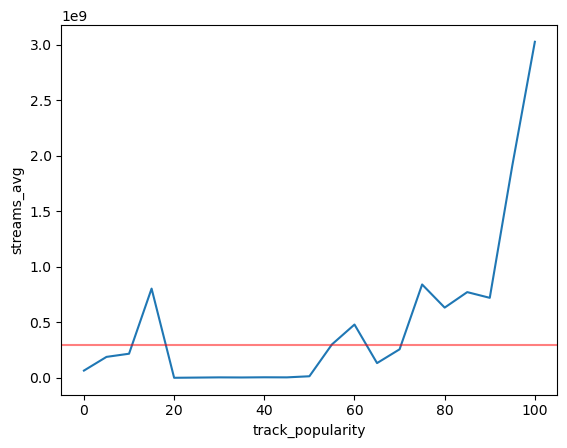

In [392]:
#Plot streams average agains popularity; the horizontal line represents 300M streams
ax = sns.lineplot(data=df_q, x='track_popularity', y='streams_avg');
plt.axhline(y=300_000_000, c='r', alpha=0.5);

<div class="alert alert-block alert-info">Though there are some clear outliers in our samples, we can see that songs with a popularity score of ~70 and above consistently have over 300M streams. With our mean absolute error of ~15, we can notify Regression Records that based on this small sample, we ought to choose songs with a predicted popularity score of 85 or higher. This sample clearly reflects some odd variablity though and may not accurately reflect the overall stream counts of songs with a given popularity score. To make a more sound prediction, we would need to address a much larger sample.</div>

In [393]:
#Evaluate difference in stream counts across popularity score increments
df_q['prev'] = df_q['streams_avg'].shift()
df_q['diff'] = df_q['streams_avg'] - df_q['prev']
df_q.head()

,track_popularity,streams_1,streams_2,streams_3,streams_avg,prev,diff
0,0,203298,187690733,7298423,6.506415e+07,NaN,NaN
1,5,35110396,27590280,502615278,1.884387e+08,6.506415e+07,1.233745e+08
2,10,146352375,235631318,268795496,2.169264e+08,1.884387e+08,2.848774e+07
3,15,1475006835,91546,935159428,8.034193e+08,2.169264e+08,5.864929e+08
4,20,69275,539657,203347,2.707597e+05,8.034193e+08,-8.031485e+08


In [395]:
#Average streams difference per popularity score difference of 5
avg_all = round(np.mean(df_q['diff']))

#Excluding lower and upper 5% to reduce outliers
q1 = df_q['diff'].quantile(0.05)
q3 = df_q['diff'].quantile(0.95)
avg_5 = round(np.mean(df_q['diff'][(df_q['diff'] > q1) & (df_q['diff'] < q3)]))

#Excluding lower and upper 25% to significantly reduce outliers
q25 = df_q['diff'].quantile(0.25)
q75 = df_q['diff'].quantile(0.75)
avg_25 = round(np.mean(df_q['diff'][(df_q['diff'] > q25) & (df_q['diff'] < q75)]))

print(f'Average MAE in streams based on sample (equivalent to popularity score MAE of 15): \
\n\nFull sample: {avg_all*3}\nExcluding lower/upper 5%: {avg_5*3}\nExcluding lower/upper 25%: {avg_25*3}')

Average MAE in streams based on sample (equivalent to popularity score MAE of 15): 

Full sample: 444208884
Excluding lower/upper 5%: 428870436
Excluding lower/upper 25%: 182711007


<div class="alert alert-block alert-info">By looking at the difference between the average sample stream counts per popularity score increments, we can see that a MAE of 15 for popularity score equals about 444M streams according to this sample. This is further off than the original predictions from our old dataset! The inconsistency of the scoring (some songs with a higher stream count were given a low popularity score, and vice versa) could indicate several things. It could mean that the 'popularity score' metric is based on other factors besides stream count. It could also reflect that these data are out of date, as they represent songs that were released through 2020 but not after. They could also (begrudgingly) indicate a lack of veracity in this dataset's target variable. We shouldn't try to predict a score based on unreliable training data. If this is the case we need to further examine other datasets and find an accurate target variable. That said, we should keep in mind that we only sampled 3 songs per popularity score across increments of 5. Different songs might yield quite different results. In order to better estimate stream count from popularity score, we would need to look at a much larger sample of songs at given score increments to get a more reliable representation. The fact that an MAE of 15 equivalates with about 183M streams when only regarding the innerquartile range, further highlights the extreme variance in this sample. Moreover we see that converting a popularity score from 1-100 to stream counts in the thousands, millions, or even billions, goes to show the relative magnitude of mere decimal places in our popularity score.</div>

## Summary

The modeling stage of our data pipeline led us to a pivot in approach. As we sought to garner data with features that would provide more predictive ability, we switched to a new dataset. Advantages of this new dataset include:
- Over 30 times as many observations as our original dataset
- Additional features including the numerical features of loudness and duration, and categorical features pertaining to genre

Disadvantages of this new dataset include:
- Songs included are only as recent as 2020
- Target variable is a popularity score from 1-100 rather than stream count, which requires additional interpretation to quantify a specific success threshold

For this analysis, we chose to build models on the new dataset upon seeing that duration and loudness seemed to be important factors in predicting a song's popularity. As removal of the categorical features improved performance of our initial Random Forest Regressor, we decided to only model based on numerical features at this time. While limiting the feature selection might hinder gains in predictive power in other models, it grants the advantage of greater song selection versatility in selecting from any genre and key in Regression Record's catalog, and it expedites the process moving forward. We proceeded to build and tune 5 models:
- Random Forest Regressor
- Extra Trees Regressor
- Gradient Boosting Regressor
- Hist Gradient Boosting Regressoor
- XGBoost Regressor

Of these, the Extra Trees regressor had the best performance with an average mean absolute error of 15.936575985093796 and standard deviation of 0.08829270949863222 across 5 folds of cross validation. It's test prediction had a mean absolute error of 15.30191608911115. We attribute the greater performance on the test set than training set to the likely presence of larger outliers in the training set. The Extra Trees Regressor ranked feature importances as follows:
1. duration (0.106840)
2. instrumentalness (0.106628)
3.	loudness (0.105952)
4.	energy (0.104153)
5.	acousticness (0.099422)
6.	tempo (0.095905)
7.	valence	(0.095804)
8.	speechiness (0.095739)
9.	danceability (0.095383)
10.	liveness (0.094174)

Finally, to quantify our popularity score in terms of streams, we took 3 samples across 21 popularity scores ranging from 0 to 100 in increments of 5. The results were inconsistent, as some songs with lower popularity scores had more streams than some songs with higher popularity scores, and vice versa. With our Extra Trees Regressor tuned to this dataset using popularity scores as the target variable, we will need to explore further insight into how well these scores reflect a song's success. In the meantime, we can use our model on songs from Regression Record's catalog to get a sense for how popular they may be as based on the rankings of this dataset.